# Whisper V2 Batch Processing Test

Model Used:[openai/whisper-large-v2](https://huggingface.co/openai/whisper-large-v2)

Resources Used:

- vCPU: 4
- Memory: 16
- GPU: 1 Nvidia T4

In [2]:
import torch
from transformers import pipeline
from transformers.pipelines.audio_utils import ffmpeg_read
import warnings
warnings.filterwarnings("ignore")
import os
import textwrap
import langchain
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from transformers import LlamaTokenizer, LlamaForCausalLM, pipeline
from InstructorEmbedding import INSTRUCTOR
from huggingface_hub import login
import os
import pandas as pd
from datetime import datetime
import time
print(os.environ['PATH'])



####################
#Setting Up Whisper
####################

MODEL_NAME = "openai/whisper-large-v2"
BATCH_SIZE = 8
FILE_LIMIT_MB = 1000
#TODO:FIX Add functionality to load in CPU if only 1 GPU available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    MODEL_NAME, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(MODEL_NAME)

pipe = pipeline(
    task="automatic-speech-recognition",
    model=MODEL_NAME,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    chunk_length_s=30,
    batch_size=BATCH_SIZE,
    torch_dtype=torch_dtype,
    device=device,
)


def transcribe(inputs, task):
    if inputs is None:
        raise gr.Error("No audio file submitted! Please upload or record an audio file before submitting your request.")
    text = pipe(inputs, 
                generate_kwargs={"task": task}, 
                return_timestamps=True)["text"]

    return text

/usr/lib/jvm/java-8-openjdk-amd64/bin:/home/cdsw/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin:/usr/lib/hadoop/bin:/usr/lib/hadoop-hdfs/bin


In [3]:
import os
import pandas as pd
from datetime import datetime
from pydub.utils import mediainfo

def get_audio_length(file_path):
    # Get audio file information
    info = mediainfo(file_path)
    # Convert duration from milliseconds to seconds and format it
    minutes, seconds = divmod(float(info['duration']), 60)
    return f"{int(minutes):02d}m {int(seconds):02d}s"


def process_audio_files(audio_folder, text_folder, task):
    log_data = pd.DataFrame(columns=['audio_file', 'text_file', 'audio_length', 'transcription_time(s)'])
    
    audio_files = [f for f in os.listdir(audio_folder) if os.path.isfile(os.path.join(audio_folder, f))]
    
    for audio_file in audio_files:
        audio_file_path = os.path.join(audio_folder, audio_file)
        start_time = time.time()
        text = transcribe(audio_file_path, task)
        end_time = time.time() # time.time()
        
        audio_length = get_audio_length(audio_file_path)
        transcription_time = end_time - start_time

        # minutes, seconds = divmod(transcription_time_seconds, 60)
        # transcription_time = f"{int(minutes):02d}m {int(seconds):02d}s"

        
        text_filename = os.path.splitext(audio_file)[0] + '.txt'
        text_file_path = os.path.join(text_folder, text_filename)
        with open(text_file_path, 'w') as text_file:
            text_file.write(text)
        
        
        log_row = {
            'audio_file': audio_file,
            'text_file': text_filename,
            'audio_length': audio_length,
            'transcription_time(s)': transcription_time
        }
        log_data.loc[len(log_data)] = log_row
        log_data.to_csv('transcription_log.csv', index=False)
    
    return log_data


audio_folder = 'audio_data'
text_folder = 'text_data'
task = 'transcribe'

log_data = process_audio_files(audio_folder, text_folder, task)


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


# Transcription Time Analysis

In [4]:
import pandas as pd

# Load the CSV file into a DataFrame
df_transcription = pd.read_csv('transcription_log.csv')

# Display the first few rows of the DataFrame to understand its structure
df_transcription.head()


,audio_file,text_file,audio_length,transcription_time(s)
0,10_20_2023.m4a,10_20_2023.txt,99m 35s,251.672843
1,10_06_2023.m4a,10_06_2023.txt,114m 24s,331.142658
2,09_22_2023.m4a,09_22_2023.txt,113m 15s,294.945811
3,09_29_2023.m4a,09_29_2023.txt,120m 55s,313.085850
4,10_12_2023.m4a,10_12_2023.txt,61m 41s,153.970856


In [5]:
def convert_to_seconds(time_str):
    """Convert a time string in the format 'Xm Ys' to seconds."""
    minutes, seconds = 0, 0
    if 'm' in time_str:
        minutes = int(time_str.split('m')[0].strip())
        if 's' in time_str:
            seconds = int(time_str.split('m')[1].split('s')[0].strip())
    else:
        seconds = int(time_str.split('s')[0].strip())
    
    return minutes * 60 + seconds

# Convert the 'audio_length' column to seconds
df_transcription['audio_length(s)'] = df_transcription['audio_length'].apply(convert_to_seconds)

# Display the updated DataFrame
df_transcription.head()


,audio_file,text_file,audio_length,transcription_time(s),audio_length(s)
0,10_20_2023.m4a,10_20_2023.txt,99m 35s,251.672843,5975
1,10_06_2023.m4a,10_06_2023.txt,114m 24s,331.142658,6864
2,09_22_2023.m4a,09_22_2023.txt,113m 15s,294.945811,6795
3,09_29_2023.m4a,09_29_2023.txt,120m 55s,313.085850,7255
4,10_12_2023.m4a,10_12_2023.txt,61m 41s,153.970856,3701


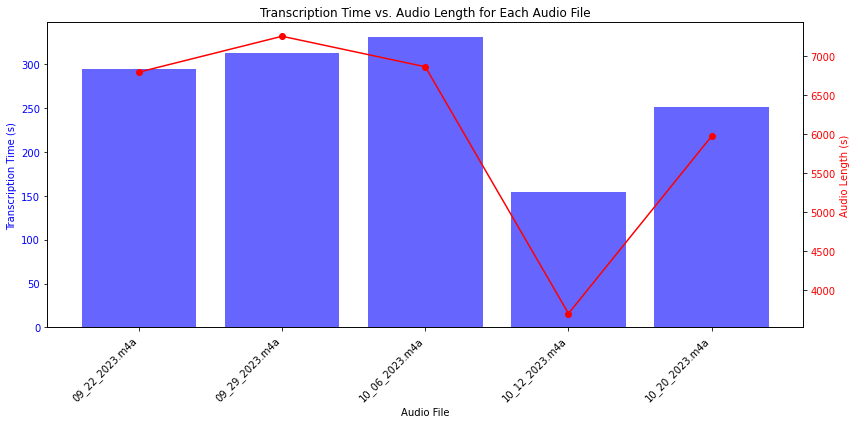

In [6]:
import matplotlib.pyplot as plt

# Sort the data based on the audio file (which seems to be named by date) for better visualization
df_transcription = df_transcription.sort_values(by='audio_file')

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Twin the axes
ax2 = ax1.twinx()

# Plot data on ax1
ax1.bar(df_transcription['audio_file'], df_transcription['transcription_time(s)'], color='b', alpha=0.6, label='Transcription Time')
ax1.set_ylabel('Transcription Time (s)', color='b')
ax1.set_xlabel('Audio File')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Transcription Time vs. Audio Length for Each Audio File')
ax1.set_xticklabels(df_transcription['audio_file'], rotation=45, ha='right')

# Plot data on ax2
ax2.plot(df_transcription['audio_file'], df_transcription['audio_length(s)'], color='r', marker='o', label='Audio Length')
ax2.set_ylabel('Audio Length (s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.tight_layout()
plt.show()


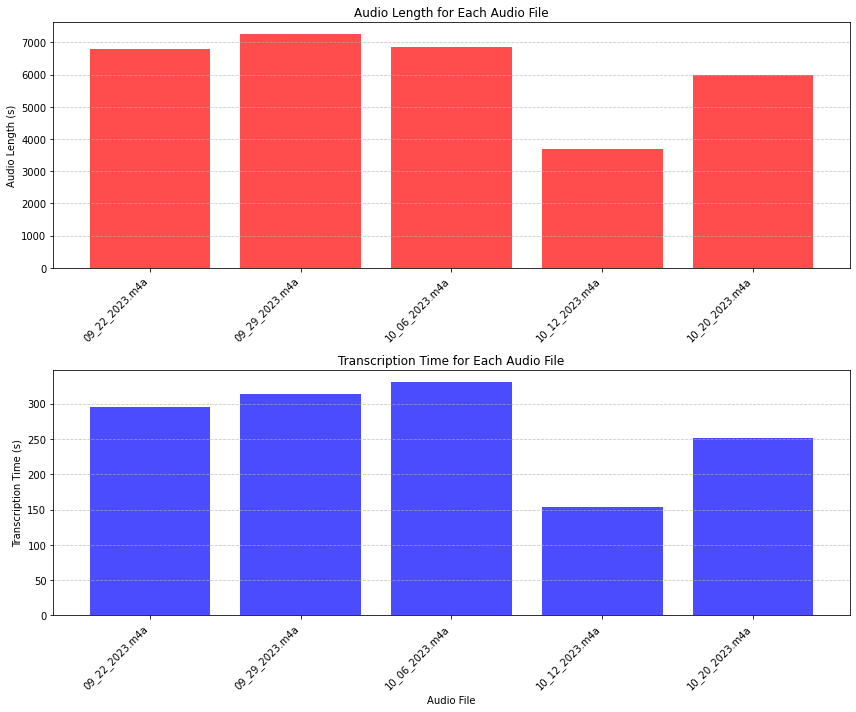

In [7]:
# Plotting audio length against each audio file
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot for Audio Length
ax1.bar(df_transcription['audio_file'], df_transcription['audio_length(s)'], color='r', alpha=0.7)
ax1.set_ylabel('Audio Length (s)')
ax1.set_title('Audio Length for Each Audio File')
ax1.set_xticklabels(df_transcription['audio_file'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Transcription Time
ax2.bar(df_transcription['audio_file'], df_transcription['transcription_time(s)'], color='b', alpha=0.7)
ax2.set_ylabel('Transcription Time (s)')
ax2.set_xlabel('Audio File')
ax2.set_title('Transcription Time for Each Audio File')
ax2.set_xticklabels(df_transcription['audio_file'], rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


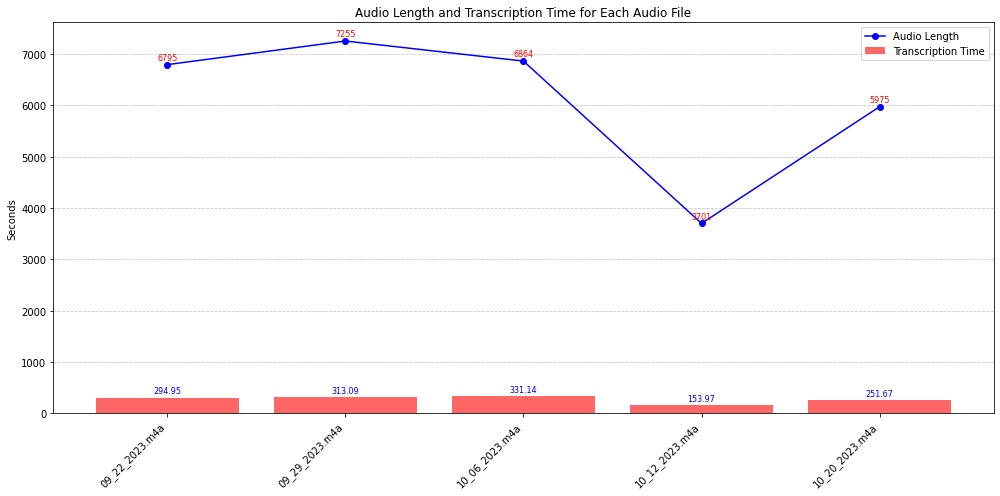

In [8]:
# Plotting audio length as a line and transcription time as bars with labels
fig, ax = plt.subplots(figsize=(14, 7))

# Bar plot for Transcription Time
bars = ax.bar(df_transcription['audio_file'], df_transcription['transcription_time(s)'], color='r', alpha=0.6, label='Transcription Time')

# Line plot for Audio Length
line, = ax.plot(df_transcription['audio_file'], df_transcription['audio_length(s)'], color='b', marker='o', label='Audio Length')

# Adding labels to bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 50, round(yval, 2), ha='center', va='bottom', color='b', fontsize=8)

# Adding labels to line graph points
for i, txt in enumerate(df_transcription['audio_length(s)']):
    ax.text(i, txt + 50, txt, ha='center', va='bottom', color='r', fontsize=8)

ax.set_ylabel('Seconds')
ax.set_title('Audio Length and Transcription Time for Each Audio File')
ax.set_xticklabels(df_transcription['audio_file'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


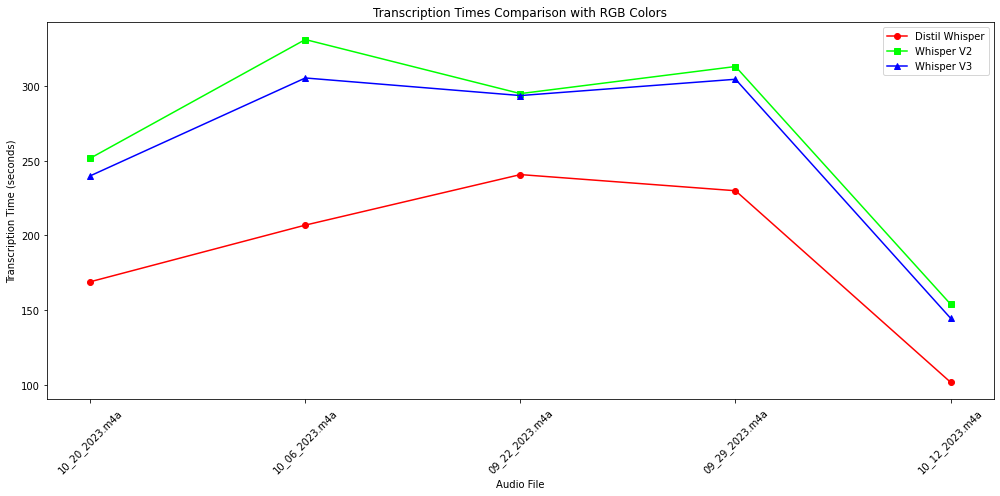

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert audio_length to a comparable numerical value (total seconds)
def convert_to_seconds(time_str):
    # Split the time string into its components
    minutes, seconds = map(int, time_str.strip('m s').split('m '))
    # Convert to total seconds
    return minutes * 60 + seconds

# Load the CSV files into pandas dataframes
df1 = pd.read_csv('distil_whisper_transcription_log.csv')
df2 = pd.read_csv('transcription_log.csv')
df3 = pd.read_csv('whisper_v3_transcription_log.csv')



# Prepare the plot with specified RGB colors
plt.figure(figsize=(14, 7))

# RGB colors for each line
colors = {
    'Distil Whisper': (1, 0, 0),  # Red
    'Whisper V2': (0, 1, 0),      # Green
    'Whisper V3': (0, 0, 1)       # Blue
}

# Plotting the line graph with RGB colors
plt.plot(df1['audio_file'], df1['transcription_time(s)'], label='Distil Whisper', marker='o', color=colors['Distil Whisper'])
plt.plot(df2['audio_file'], df2['transcription_time(s)'], label='Whisper V2', marker='s', color=colors['Whisper V2'])
plt.plot(df3['audio_file'], df3['transcription_time(s)'], label='Whisper V3', marker='^', color=colors['Whisper V3'])

# Add titles and labels
plt.title('Transcription Times Comparison with RGB Colors')
plt.xlabel('Audio File')
plt.ylabel('Transcription Time (seconds)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()

# Show the plot with the RGB colors
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


<Figure size 1008x504 with 0 Axes>

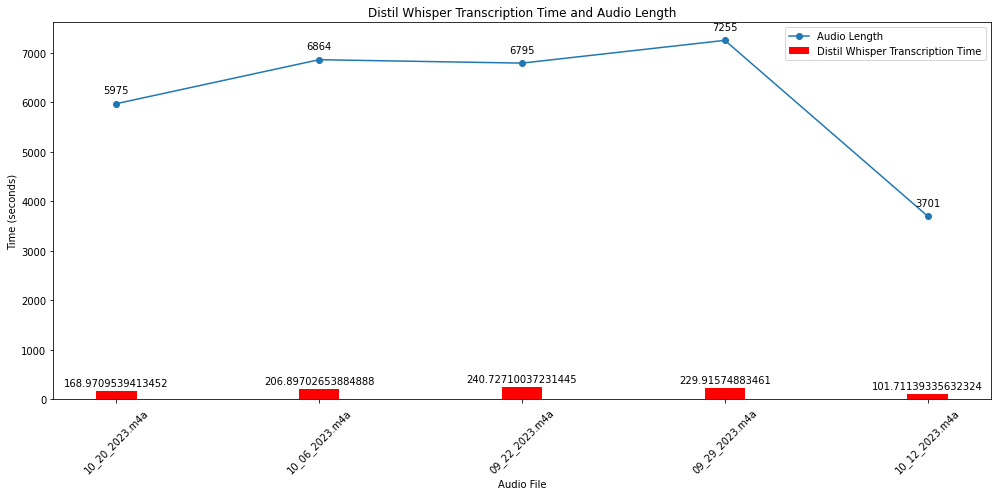

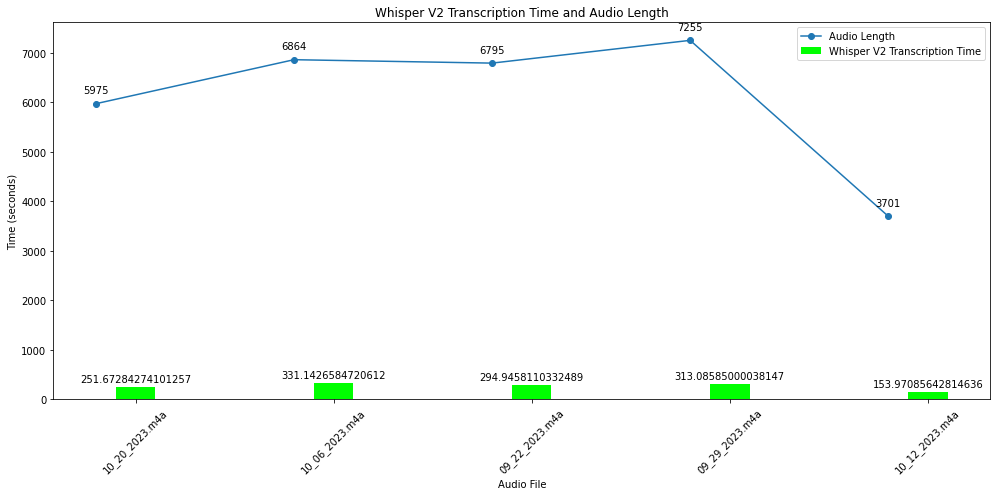

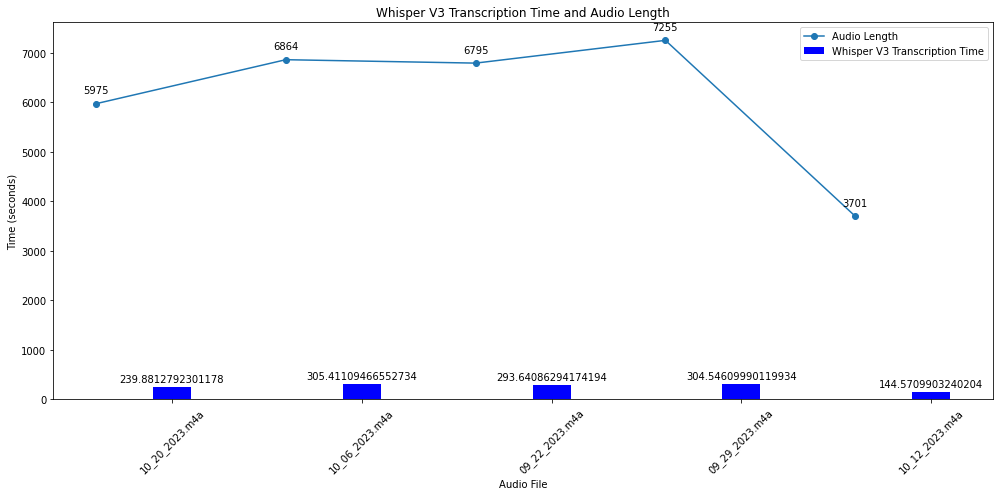

In [5]:
import numpy as np

# Prepare the combined plot with transcription times as bar plots and audio length as a line graph

plt.figure(figsize=(14, 7))

# Setting the width of the bars
bar_width = 0.2

# Calculating the position of the bars
r1 = np.arange(len(df1['audio_file']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Convert audio_length to a comparable numerical value (total seconds)
def convert_to_seconds(time_str):
    # Split the time string into its components
    minutes, seconds = map(int, time_str.strip('m s').split('m '))
    # Convert to total seconds
    return minutes * 60 + seconds

# Apply conversion to the 'audio_length' column for all dataframes
df1['audio_length_sec'] = df1['audio_length'].apply(convert_to_seconds)
df2['audio_length_sec'] = df2['audio_length'].apply(convert_to_seconds)
df3['audio_length_sec'] = df3['audio_length'].apply(convert_to_seconds)

# Function to create an individual plot for each model with bar and line graph
def create_individual_plot(df, model_name, bar_color, bar_positions):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Create the bar plot for transcription times
    bars = ax.bar(bar_positions, df['transcription_time(s)'], color=bar_color, width=bar_width, label=model_name + ' Transcription Time')
    
    # Adding the values on the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    # Plot the line graph for the audio lengths
    line = ax.plot(df['audio_file'], df['audio_length_sec'], label='Audio Length', marker='o', linestyle='-', color='tab:blue')
    
    # Adding the values on the line points
    for i, txt in enumerate(df['audio_length_sec']):
        ax.annotate(txt, (df['audio_file'][i], df['audio_length_sec'][i]), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Add titles and labels
    ax.set_title(f'{model_name} Transcription Time and Audio Length')
    ax.set_xlabel('Audio File')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(df['audio_file'], rotation=45)
    ax.set_ylabel('Time (seconds)')

    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Create the individual plots for each model
create_individual_plot(df1, 'Distil Whisper', colors['Distil Whisper'], r1)
create_individual_plot(df2, 'Whisper V2', colors['Whisper V2'], r2)
create_individual_plot(df3, 'Whisper V3', colors['Whisper V3'], r3)


In [8]:
# Create a new DataFrame to combine the transcription times from all three models
combined_transcription_times_df = pd.DataFrame({
    'Audio File': df1['audio_file'],
    'Distil Whisper Time (s)': df1['transcription_time(s)'],
    'Whisper V2 Time (s)': df2['transcription_time(s)'],
    'Whisper V3 Time (s)': df3['transcription_time(s)']
})



# Adding the original audio length column to the combined DataFrame
combined_transcription_times_df['Audio Length (s)'] = df1['audio_length_sec']


# Convert the time from seconds to minutes in the combined DataFrame
combined_transcription_times_df['Distil Whisper Time (min)'] = combined_transcription_times_df['Distil Whisper Time (s)'] / 60
combined_transcription_times_df['Whisper V2 Time (min)'] = combined_transcription_times_df['Whisper V2 Time (s)'] / 60
combined_transcription_times_df['Whisper V3 Time (min)'] = combined_transcription_times_df['Whisper V3 Time (s)'] / 60
combined_transcription_times_df['Audio Length (min)'] = combined_transcription_times_df['Audio Length (s)'] / 60

# Drop the seconds columns to avoid confusion
combined_transcription_times_df.drop(['Distil Whisper Time (s)', 'Whisper V2 Time (s)', 'Whisper V3 Time (s)', 'Audio Length (s)'], axis=1, inplace=True)

# Display the updated DataFrame with times in minutes
combined_transcription_times_df.head()


,Audio File,Distil Whisper Time (min),Whisper V2 Time (min),Whisper V3 Time (min),Audio Length (min)
0,10_20_2023.m4a,2.816183,4.194547,3.998021,99.583333
1,10_06_2023.m4a,3.448284,5.519044,5.090185,114.400000
2,09_22_2023.m4a,4.012118,4.915764,4.894014,113.250000
3,09_29_2023.m4a,3.831929,5.218098,5.075768,120.916667
4,10_12_2023.m4a,1.695190,2.566181,2.409517,61.683333
